In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from datetime import datetime
import warnings

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

sys.path.insert(1, '/home/jovyan')
sys.path.insert(2, sys.path[0] + '/src')
os.environ["GOOGLE_CLOUD_PROJECT"] = 'wx-bq-poc'
warnings.filterwarnings('ignore')

from cmd_akl import CVM_CMDAKLFeature
import util

In [3]:
PROJECT = 'wx-bq-poc'
BUCKET = 'wx-personal'
PREFIX = 'denny/tweedie_regression'

In [4]:
from matplotlib import gridspec

def calplot(df, title, bins, limit=1000):
    _df = df[['pred', 'target']].sort_values(by='pred')
    _df = pd.cut(_df['pred'], bins)
    _df = pd.DataFrame({'x': _df.apply(lambda x: x.mid)})
    _df = df.merge(_df, left_index=True, right_index=True)
    _df = _df.groupby(by='x').agg({'target': 'mean', 'pred': 'mean'}).reset_index()
    _df = _df.dropna(how='any')
        
    fig = plt.figure(figsize=(10,10))
    spec = gridspec.GridSpec(
        ncols=1, nrows=2, height_ratios=[3, 1]
    )
    
    ax0 = fig.add_subplot(spec[0])
    ax0.set_title(title)
    ax0.grid()
    ax0.plot(np.arange(-limit,limit), np.arange(-limit,limit), '--', color='k')
    ax0.plot(_df['pred'], _df['target'])
    ax0.set_xlim(-limit, limit)
    ax0.set_ylim(-limit, limit)
    ax0.set_ylabel('true')

    ax1 = fig.add_subplot(spec[1], sharex = ax0)
    ax1.hist(df['pred'], bins=bins, edgecolor='w')
    ax1.grid()
    ax1.set_yscale('log')
    ax1.set_xlabel('pred')
    ax1.set_ylabel('volume')

    plt.show()

def distplot(y, labels, log=True):
    bins = 200
    plt.figure(figsize=(25,10))
    for y_i, label in zip(y, labels):
        plt.hist(y_i, bins=bins, range=(-1000, 1000), histtype='step', label=label)
    if log:
        plt.yscale('log')
    plt.grid()
    plt.legend()
    plt.show()

In [5]:
sql = ''' 
    SELECT crn, ref_dt, as_wkly_spd_avg
    FROM  `gcp-wow-rwds-ai-mmm-super-dev.DEV_MMM.MMM_FINAL_FEATURES_CAMP_TUR1060` 
    WHERE offer_type = 'SS1' 
        AND ref_dt BETWEEN '2021-06-06' AND '2021-07-18'
'''

true_df = util.sql2df(PROJECT, sql)

### Existing model

In [6]:
pred_df = util.pq2df('gs://wx-personal/denny/direct_inc_sales_model/SS1_old/scoring/output/2021-09-09/processed_data/')

In [7]:
joined_df = pred_df.merge(true_df, left_on=['crn','ref_dt'], right_on=['crn','ref_dt'])
joined_df.rename(columns={'score': 'pred', 'as_wkly_spd_avg': 'target'}, inplace=True)

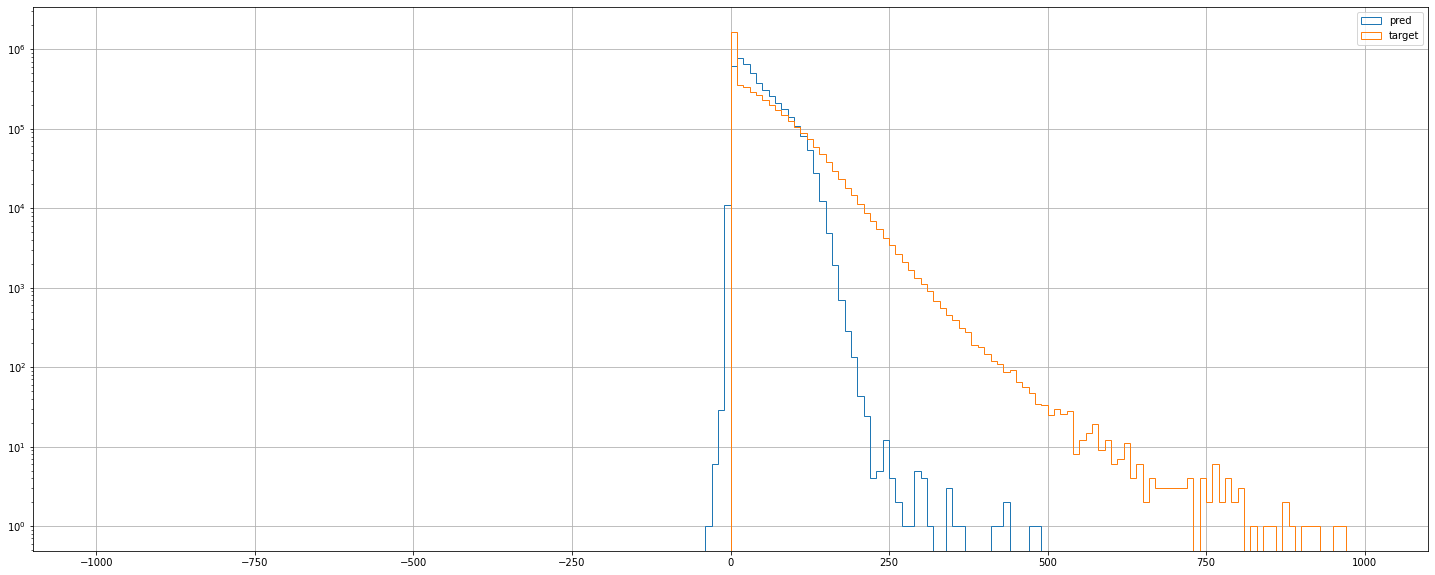

In [8]:
y = [joined_df.pred, joined_df.target]
labels = ['pred', 'target']
distplot(y, labels, log=True)

### Tweedie model

In [12]:
class SS1_CMDAKLFeature(CVM_CMDAKLFeature):

    def __init__( 
        self, 
        project='wx-bq-poc', 
        bucket='wx-personal', 
        prefix=None,
        akl_config=None,
        cmd_config=None
    ):

        super(SS1_CMDAKLFeature, self).__init__(
            project=project, 
            bucket=bucket, 
            prefix=prefix,
            akl_config=akl_config,
            cmd_config=cmd_config
        )
    
    def customize_conf_yaml(self, conf_dict):
        conf_dict['global']['run_date'] = datetime.today().strftime('%Y-%m-%d')
        conf_dict['global']['modeller'] = 'denny'
        conf_dict['global']['objective'] = 'regression'
        conf_dict['global']['target'] = 'as_wkly_spd_avg'
        conf_dict['global']['metric'] = ['rmse', 'mse']
        
        conf_dict['preprocessor']['params']['train_test_holdout']['split_type'] = 'by_time'
        conf_dict['preprocessor']['params']['train_test_holdout']['by_time']['inTimeEndDate'] = '2021-01-01'
        conf_dict['preprocessor']['params']['train_test_holdout']['by_time']['inTimeTrainTestSplit'] = 80
        conf_dict['global']['sample_weight'] = 'sample_w'
        
        conf_dict['feature_selection']['max_cut'] = 0.9
#         conf_dict['fit']['gbdt_hyper_params']['tweedie_variance_power'] = '1.5,1.6,1.7' 
        return conf_dict
    
    def customize_excel(self, exce_dict):
    
        # ================================ #
        # read excel config into DataFrame #
        # ================================ #
        mars_data_dictionary_df = exce_dict['mars_data_dictionary']
        feature_spec_num_df = exce_dict['feature_spec_num']
        feature_spec_cat_df = exce_dict['feature_spec_cat']
        constrain_df = exce_dict['Constrain']

        # ======================================= #
        # ignore target, weight and flux features #
        # ======================================= #
        feature_spec_num_df.loc[feature_spec_num_df.feature == 'as_wkly_spd_avg', 'input'] = 'ignore'
        feature_spec_num_df.loc[feature_spec_num_df.feature == 'sample_w', 'input'] = 'ignore'
        feature_spec_num_df.loc[feature_spec_num_df.feature.str.contains('_flx_'), 'input'] = 'ignore'

        feature_spec_cat_df.loc[feature_spec_cat_df.feature == 'as_wkly_spd_avg', 'input'] = 'ignore'
        feature_spec_cat_df.loc[feature_spec_cat_df.feature == 'sample_w', 'input'] = 'ignore'
        feature_spec_cat_df.loc[feature_spec_cat_df.feature.str.contains('_flx_'), 'input'] = 'ignore'

        # ----------------------------------- #
        # Add customer configuration here !!! #
        # ----------------------------------- #
        feature_spec_num_df.loc[feature_spec_num_df.feature == 'redeem_flag', 'input'] = 'ignore'
        feature_spec_cat_df.loc[feature_spec_cat_df.feature == 'redeem_flag', 'input'] = 'ignore'
        constrain_df.loc[0] = ['as_wkly_spd_avg', f'f0_as_wkly_spd_avg', 'num', '-1000', '1000', '']

        return exce_dict

prefix = f'{PREFIX}/aliu/l2'

ss1_cmd_akl = SS1_CMDAKLFeature(
    project=PROJECT, 
    bucket=BUCKET, 
    prefix=prefix,
)

# ss1_cmd_akl.run()
ss1_cmd_akl.run_akl('gs://wx-personal/denny/tweedie_regression/aliu/cmd/output/')

CMD Pivoter Finished @ 16/09/2021 09:48:15
Loading CMD Output Parquet ....
Loading CMD Output Parquet Done
               bash input command:                
--------------------------------------------------
gcloud --project wx-bq-poc container clusters get-credentials project-melon --zone=us-west1-a
/home/jovyan/.local/bin/argo submit local/denny/tweedie_regression/aliu/l2/akl/config/argo_base.yaml
               bash output results:               
--------------------------------------------------
Fetching cluster endpoint and auth data.
kubeconfig entry generated for project-melon.
Name:                denny-tweedie-regression-aliu-l287dqq
Namespace:           default
ServiceAccount:      default
Status:              Pending
Created:             Thu Sep 16 09:49:05 +0000 (now)
Parameters:          
  SPECPATH:          gs://wx-personal/denny/tweedie_regression/aliu/l2/akl/config/config_base.yaml
  VERSION:           0.5



In [ ]:
# my_gs_path = 'wx-personal/denny/tweedie_regression/akl/output/denny-tweedie-regression-l2/2021-09-15/scoring/scored_T.parquet'
# test = util.pq2df(my_gs_path)
# y = [test.pred, test.target]
# labels = ['pred', 'target']
# distplot(y, labels, log=True)